In [1]:
from __future__ import division, unicode_literals

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt
import pylab as pl

# Чтение данных

In [2]:
train = pd.read_csv('train.csv', encoding='utf-8', 
                    dialect='excel', lineterminator='\n')

assert(train.columns[-1] == 'retweet_count')

# Пример вычисления признаков

In [3]:
def df2features(df):
    return np.array([
        df['user.id'],
        df['user.followers_count'],
    ]).transpose()

train_x = df2features(train)
train_y = train['retweet_count'] > 20

# Построение модели

Пример вычисления площади под ROC-кривой на обучающей выборке.

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation, svm

from sklearn.metrics import roc_curve, auc

In [5]:
model_dtc = DecisionTreeClassifier()
model_lr = LogisticRegression(penalty='l1', tol=0.01)
model_rfc = RandomForestClassifier(n_estimators = 10)
model_knc = KNeighborsClassifier(n_neighbors = 10)

Кросс-валидация

In [6]:
train_x_ROC, test_x_ROC, train_y_ROC, test_y_ROC = cross_validation.train_test_split(train_x, train_y, test_size=0.2)

In [7]:
kfold = 5 #количество подвыборок для валидации
acc_val = {}
scores = cross_validation.cross_val_score(model_dtc, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['DecisionTreeClassifier'] = scores.mean()
scores = cross_validation.cross_val_score(model_lr, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['LogisticRegression'] = scores.mean()
scores = cross_validation.cross_val_score(model_rfc, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['RandomForestClassifier'] = scores.mean()
scores = cross_validation.cross_val_score(model_knc, train_x, train_y, cv = kfold, scoring='accuracy')
acc_val['KNeighborsClassifier'] = scores.mean()


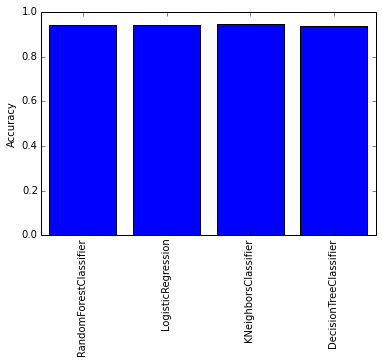

In [15]:
plt.bar(range(len(acc_val)), acc_val.values(), align='center')
plt.xticks(range(len(acc_val)), acc_val.keys(), rotation='vertical')
pl.ylabel('Accuracy')
plt.show()

Визуализация ROC-кривой

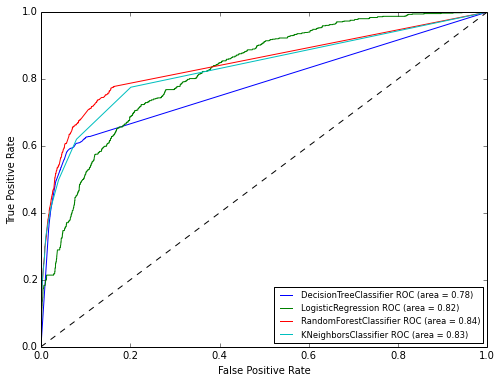

In [12]:
pl.clf()
plt.figure(figsize=(8,6))
#DecisionTreeClassifier
probas = model_dtc.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('DecisionTreeClassifier',roc_auc))
#LogisticRegression
probas = model_lr.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression',roc_auc))
#RandomForestClassifier
probas = model_rfc.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandomForestClassifier',roc_auc))
#KNeighborsClassifier
probas = model_knc.fit(train_x_ROC, train_y_ROC).predict_proba(test_x_ROC)
fpr, tpr, thresholds = roc_curve(test_y_ROC, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('KNeighborsClassifier',roc_auc))

pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()